In [42]:
#https://medium.com/techbloghotmart/o-que-s%C3%A3o-s%C3%A9ries-temporais-e-como-aplicar-em-machine-learning-6ea5d94bec78
#https://machinelearningmastery.com/time-series-data-stationary-python/
#https://github.com/je-suis-tm/quant-trading
#https://github.com/lukstei/trading-backtest
#https://github.com/dv-lebedev/pair-trading-view

import numpy as np
import pandas as pd
import os
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import statistics
import matplotlib.pyplot as plt

In [57]:
# http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/

#p-value > 0.05: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
#p-value <= 0.05: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
class StationarityTests:
    def __init__(self, significance=.05):
        self.SignificanceLevel = significance
        self.pValue = None
        self.isStationary = None
        self.ADFTestStatistic = None
        
    def CheckStationarity(self, y, x, printResults = False):
        model = model_ols(y, x)

        #Dickey-Fuller test:
        adfTest = ts.adfuller(model.resid)
        
        self.pValue = adfTest[1]
        self.ADFTestStatistic = adfTest[0:1][0]
        
        if (self.pValue < self.SignificanceLevel):
            self.isStationary = True
        else:
            self.isStationary = False
        
        if printResults:
            print('Augmented Dickey-Fuller Test Results:')
            print('ADF Test Statistic    ', adfTest[0:1][0])
            print('P-Value               ', adfTest[1:2][0])
            print('# Lags Used           ', adfTest[2:3][0])
            print('# Observations Used   ', adfTest[3:4][0])
            
            dfResults = pd.Series()
            #Add Critical Values
            for key,value in adfTest[4].items():
                dfResults['Critical Value (%s)'%key] = value
            print(dfResults)
            
            print("Is the time series stationary? {0}".format(self.isStationary))

def model_ols(y, x):
    x = sm.add_constant(x)
    model = sm.OLS(y, x).fit()
    return model

def namefile(file):
    return os.path.splitext(file)[0]

def checkStationarity(x, y, printResults = True):
    check = StationarityTests()
    return check.CheckStationarity(x, y, printResults = printResults)
    
# check cointegrated pairs from dataframe
def find_cointegrated_pairs(data, num_pairs=0):
    sTest = StationarityTests()
    rows = []
    isBreak = False
        
    for numerador in data.columns:
        for denominador in data.columns:
            if (numerador == denominador):
                continue

            sTest.CheckStationarity(data[numerador], data[denominador])
            if(sTest.isStationary):
                rows.append([numerador,denominador,sTest.pValue, sTest.ADFTestStatistic])
        
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break
            
    df_pairs = pd.DataFrame(rows, columns=['Independente', 'Dependente', 'pValue', 'ADFTestStatistic'])
    return df_pairs

# check cointegrated pairs from directory of csv's
def find_cointegrated_pairs_foldercsv(path, num_pairs=0):
    test = StationarityTests()
    rows = []
    isBreak = False
    
    # for each all files csv in directory 'datasets', read
    for fnum in os.listdir(path):
        # read the first csv
        num = pd.read_csv(path + '/'+fnum)['Fechamento']
        
        for fden in os.listdir(path):
            csv_name1 = namefile(fnum)
            csv_name2 = namefile(fden)

            # continue if it is the same csv
            if(csv_name1 == csv_name2):
                continue

            # read then second csv
            den = pd.read_csv(path+'/'+fden)['Fechamento']
            test.CheckStationarity(num, den)

            if(test.isStationary):
                rows.append([csv_name1,csv_name2,test.pValue, test.ADFTestStatistic])
            
            # break for two
            isBreak = (num_pairs > 0 and len(rows) >= num_pairs)
            if (isBreak == True): break
        
        # break for one
        if (isBreak == True): break
            
    df_pairs = pd.DataFrame(rows, columns=['Independente', 'Dependente', 'pValue', 'ADFTestStatistic'])
    return df_pairs

def graphicShow(data, y_name, x_name):
    y = data[y_name]
    x = data[x_name]
    
    model=sm.OLS(y, x).fit()
    model=model_ols(y, x)
    std = statistics.stdev(model.resid)
    entry_threshold = 2 # entrada em 2 desvio padrão

    #plt.figure(figsize=(15,6))
    plt.figure(figsize=(10,5))
    plt.plot(model.resid)
    plt.ylabel('Residual')
    plt.title(y_name + ' / ' + x_name)

    plt.axhline(0, linewidth=1,color='black',label='mean') # Add the mean of residual
    plt.axhline(entry_threshold*std, color='green', linestyle='--',label='trade')
    plt.axhline(-entry_threshold*std, color='green', linestyle='--')

    plt.legend()
    plt.show()

### Test with csv

In [44]:
y = pd.read_csv('datasets-b3/AALR3.csv')['Fechamento']
x = pd.read_csv('datasets-b3/ALSO3.csv')['Fechamento']

par = StationarityTests()
par.CheckStationarity(y, x, printResults = True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -3.6373142127726843
P-Value                0.005086448368083348
# Lags Used            0
# Observations Used    91
Critical Value (1%)    -3.504343
Critical Value (5%)    -2.893866
Critical Value (10%)   -2.584015
dtype: float64
Is the time series stationary? True


### Read CSV

In [45]:
df = pd.read_csv('datasets/data.csv')
data = df[df.columns.difference(['Data'])]

## Single test

In [46]:
checkStationarity(data['ABCB4'], data['AZUL4'], printResults = True)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic     -3.2141908124356218
P-Value                0.01917781427486066
# Lags Used            0
# Observations Used    91
Critical Value (1%)    -3.504343
Critical Value (5%)    -2.893866
Critical Value (10%)   -2.584015
dtype: float64
Is the time series stationary? True


### Pairs Cointegrated

In [47]:
pairs = find_cointegrated_pairs(data, 10)
pairs

,Independente,Dependente,pValue,ADFTestStatistic
0,AALR3,ABCB4,0.023039,-3.150434
1,AALR3,ALSO3,0.005086,-3.637314
2,AALR3,ALUP11,0.012425,-3.359362
3,AALR3,ALUP4,0.021314,-3.177666
4,AALR3,AMAR3,0.040183,-2.946679
5,AALR3,ANIM3,0.038146,-2.966476
6,AALR3,ARZZ3,0.009324,-3.451473
7,AALR3,AZUL4,0.008761,-3.471101
8,AALR3,BBAS3,0.002269,-3.869760
9,AALR3,BBDC3,0.013209,-3.339337


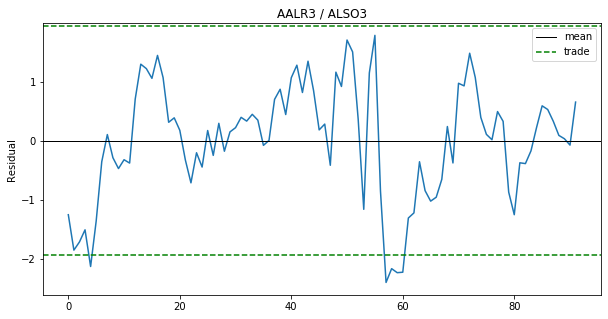

In [58]:
graphicShow(data, 'AALR3', 'ALSO3')

In [56]:
model = model_ols(data['AALR3'], data['ALSO3'])
#model.resid[len(model.resid)-1]
model.resid.iloc[-1]

0.6543942463137533

In [54]:
model.resid

0    -1.249669
1    -1.848616
2    -1.709941
3    -1.505070
4    -2.124991
        ...   
87    0.329789
88    0.091028
89    0.034301
90   -0.072869
91    0.654394
Length: 92, dtype: float64

## Graphic Cointegrated Pairs

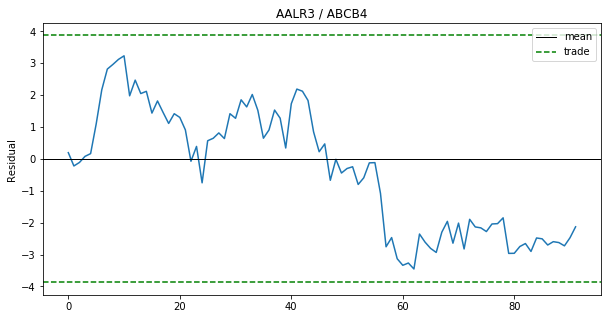

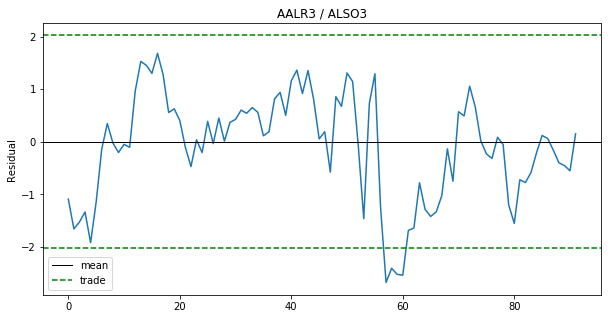

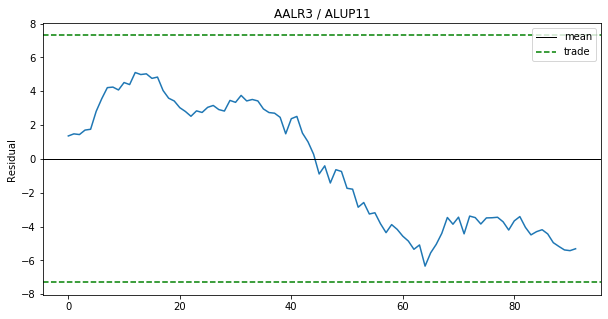

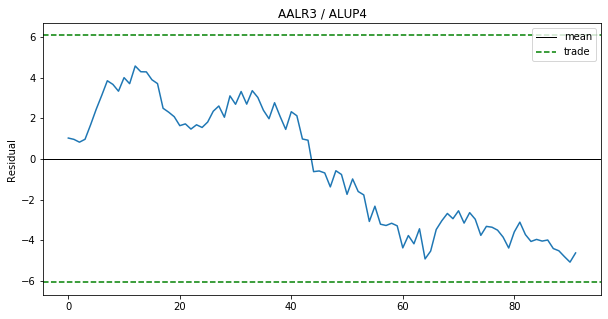

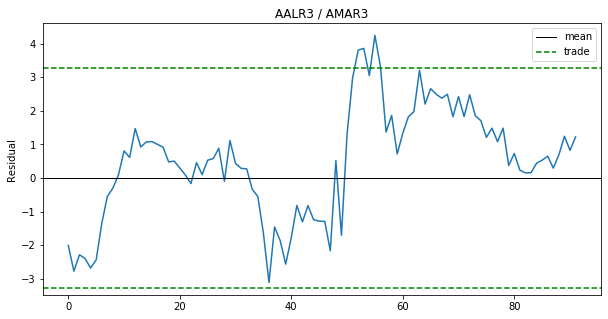

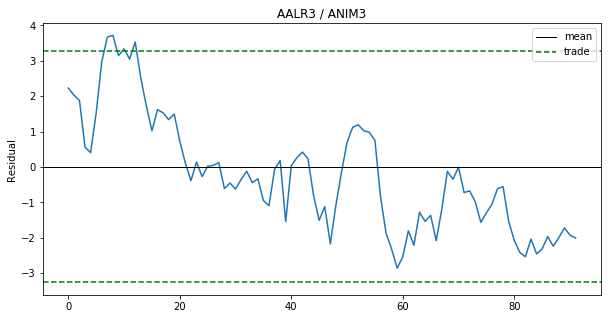

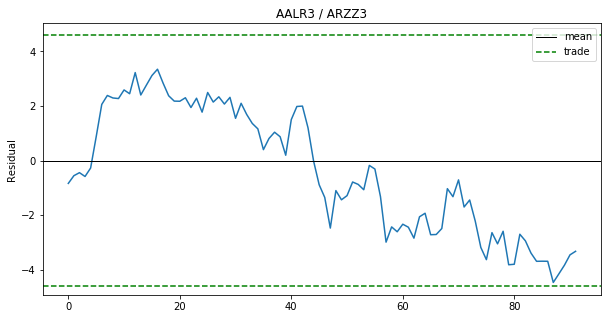

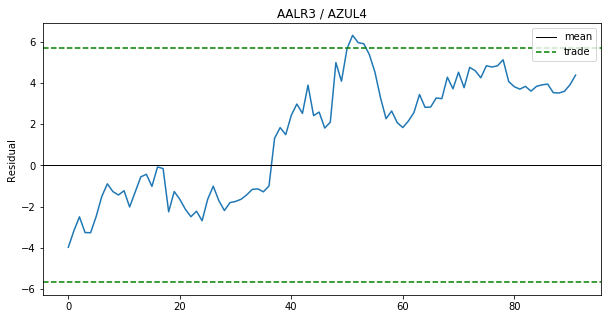

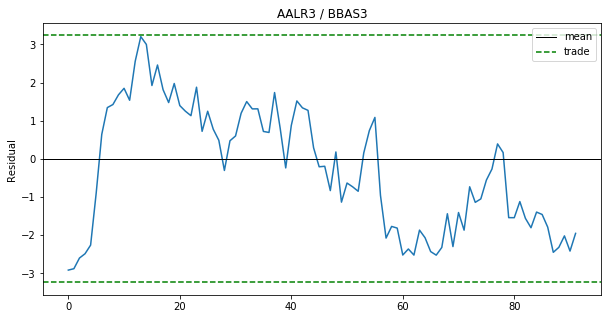

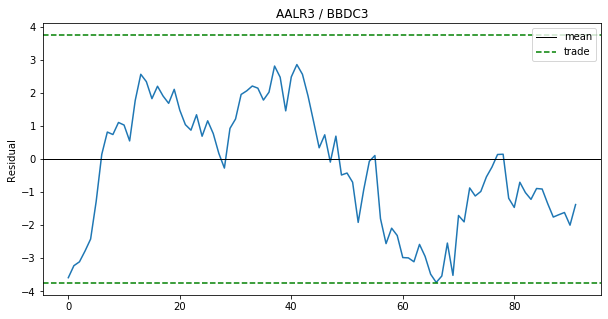

In [50]:
for i, j in pairs.iterrows():
    graphicShow(data, j['Independente'], j['Dependente'])